In [1]:
%load_ext sql

# 1) An Introduction to Window Framing

In this lesson, we'll learn about window framing, which lets us specify a window smaller than the partition. For example, with framing, we can precisely define a window that starts from the beginning of the result set and stops at the current row or define a window containing three rows before and three rows after the current row.

With frames, we can define a **window containing exactly those rows** in relation to the current row that should be considered when computing the results.

After you finish this lesson, you'll have a good understanding of the following:

* What the window framing is, and why it's important for the accuracy of the query's results

* Defining window frames and the difference between `ROW` and `RANGE`

* Applying window frames to running and moving aggregates

# 2) Window Framing Syntax

Window framing defines two endpoints in relation to the current row within the partition. The calculation applies to the frame based on the given ordering.

The standard SQL framing specification includes a ROWS, RANGE, or GROUPS option. To define a window frame, we can use the following syntaxes:

* `ROWS BETWEEN starting expression AND ending expression`

* `RANGE BETWEEN starting expression AND ending expression`

* `GROUPS BETWEEN starting expression AND ending expression`

The `starting expression` supports the following terms:

| Framing Term        | Definition                                                                             |
|---------------------|----------------------------------------------------------------------------------------|
| N PRECEDING         | The frame starts at Nth rows before the current row. Only supported with ROWS keyword. |
| UNBOUNDED PRECEDING | The frame starts at the first row of the partition.                                    |
| CURRENT ROW         | The row of the current calculation.                                                    |

Also, the `ending expression` supports the following terms:

| Framing Term        | Definition                                                                              |
|---------------------|-----------------------------------------------------------------------------------------|
| M FOLLOWING         | The frame ends at the Mth row after the current row. Only supported with ROWS keyboard. |
| UNBOUNDED FOLLOWING | The frame ends at the final row of the partition.                                       |
| CURRENT ROW         | The row of the current calculation.                                                     |

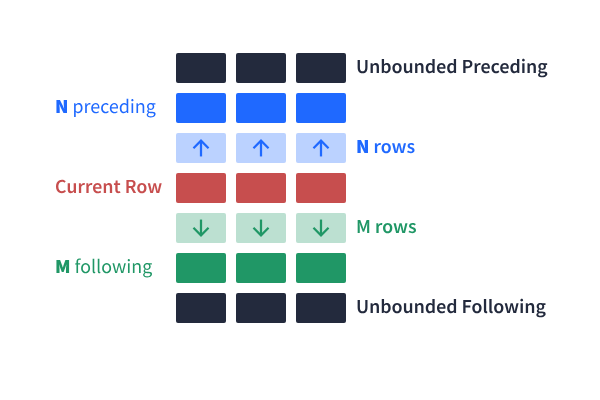

Window framing allows us to look around the neighborhood of a row. For example, we might want to calculate in a sliding window that looks at the previous, current, and subsequent value of sales quantity and **average them** as follows:

```
SELECT *,
       AVG(quantity) OVER(ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING) AS avg_quantity
  FROM apple_sales_quantity_by_month;
```

# 3) The RANGE and ROWS Operators

To better understand the window framing concept, consider the following table, which shows details of sold iPhones reported at the end of each month from January through June 2022.

| sales_date | brand | quantity |
|------------|-------|----------|
| 2022-01-31 | Apple | 50       |
| 2022-02-28 | Apple | 40       |
| 2022-03-31 | Apple | 25       |
| 2022-04-30 | Apple | 30       |
| 2022-05-31 | Apple | 47       |
| 2022-06-30 | Apple | 40       |

Let's assume we're asked to calculate the **running total quantity of sold iPhones**. The query below returns the desired output:

```sql
SELECT *,
       SUM(quantity) OVER(ORDER BY sales_date
                          RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS running_total_quantity
  FROM apple_sales_quantity_by_month;
```

Two possible frame expressions that calculate accumulating aggregate like a running total are:

```sql
ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW

RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
```

Later in this lesson, we'll discuss the difference between `ROWS` and `RANGE` and why we prefer to use `ROWS` instead of `RANGE` for defining frames.

## Instructions

Write a query that returns a **reverse** running total quantity of sold iPhones.

1. Create a frame within the `apple_sales_quantity_by_month` table that starts at the current row and includes all the rows to the end of the window.

1. Return all the table's columns and a new column containing the result of applying the `SUM()` function to the frame created in the previous step, aliased as `reverse_running_total_quantity`.

In [ ]:
%%sql
SELECT *,
       SUM(quantity) OVER(ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) as reverse_running_total_quantity
  FROM apple_sales_quantity_by_month

# 4) The RANGE and ROWS Operators - Syntax Shortcut

We also have a way to obtain the same kind of result in a shorter way:

1. Without `ORDER BY` in `OVER()`, the default frame specification is:

    `ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING`

1. With `ORDER BY` in `OVER()`, the default frame specification is:

    `RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW`

Therefore, we can just  add an `ORDER BY` expression to an `OVER()` clause, instead of . 

```sql
SELECT *,
       SUM(quantity) OVER(ORDER BY sales_date
                          RANGE BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS running_total_quantity
  FROM apple_sales_quantity_by_month;
```

we can calculate the running total as follows.
```sql
SELECT *,
       SUM(quantity) OVER(ORDER BY sales_date) AS running_total_quantity
  FROM apple_sales_quantity_by_month;
```


## Instructions

Write a query that returns the running average quantity of phone sales.

1. Create a frame within the `apple_sales_quantity_by_month` table that starts from the beginning of the partition to the current row.

1. Return all the table's columns and a new column containing the result of applying the `AVG()` function to the frame created in the previous step, aliased as `running_avg`.

In [ ]:
%%sql
SELECT *,
       AVG(quantity) OVER(ORDER BY sales_date) AS running_avg
FROM apple_sales_quantity_by_month

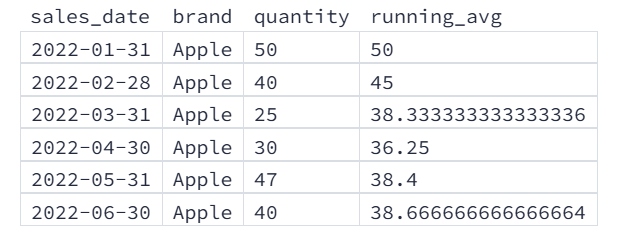

# 5) Framing using n_PRECEDING and n_FOLLOWING


On this screen, we'll learn how to create a frame by specifying a number of rows to include. This syntax can only be used with `ROWS` and allows us to define a frame that consists of a number of rows before, after, or before and after the current row. Let's discover `n PRECEDING` and `n FOLLOWING` options by calculating the sum of every two preceding sales quantities from a table called `phone_sales_quantity_by_month` that shows sales for Apple and Samsung phones.

```sql
SELECT *,
       SUM(quantity) OVER(PARTITION BY brand
                         ORDER BY sales_date
                         ROWS BETWEEN 2 PRECEDING AND 1 PRECEDING) AS sum_two_preceding
  FROM phone_sales_quantity_by_month;
```

| sales_date | brand   | quantity | sum_two_preceding |
|------------|---------|----------|-------------------|
| 2022-01-31 | Apple   | 110      |                   |
| 2022-02-28 | Apple   | 60       | 110               |
| 2022-03-31 | Apple   | 85       | 170               |
| 2022-04-30 | Apple   | 134      | 145               |
| 2022-05-31 | Apple   | 90       | 219               |
| 2022-06-30 | Apple   | 100      | 224               |
| 2022-01-31 | Samsung | 117      |                   |
| 2022-02-28 | Samsung | 75       | 117               |
| 2022-03-31 | Samsung | 86       | 192               |
| 2022-04-30 | Samsung | 124      | 161               |
| 2022-05-31 | Samsung | 80       | 210               |
| 2022-06-30 | Samsung | 89       | 204               |

As shown, two partitions exist in the `phone_sales_quantity_by_month` table — Apple and Samsung — and the frame should consist of the two previous rows of the current row. The frame starts two rows before the current row and ends one row before the current row. Since the first row in each partition doesn't have preceding rows, the first frame is empty. So the first sum of both partitions is `NULL`.

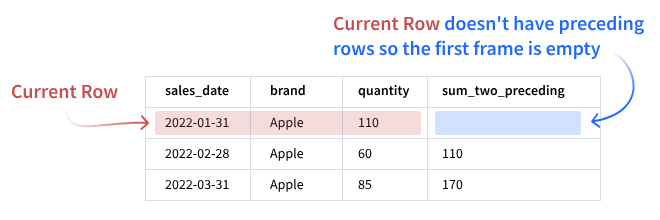

The second frames include **only the first row** of each partition and the second row's output is the first row's quantity.

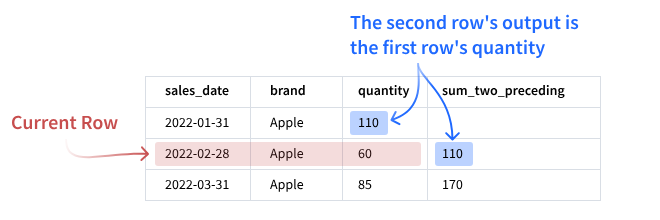

The remaining rows in each partition return the sum of the two previous rows.

Let's explore the `n FOLLOWING` option by executing one more query that returns the average revenue for every row calculated by taking **one previous row, the current row and one following row.**

```sql
SELECT *,
       AVG(revenue) OVER(PARTITION BY brand
                         ORDER BY sales_date
                         ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING) AS average_revenue
  FROM phone_sales_revenue_by_month;
```

## Instructions

Write a query that calculates the average revenue of all previous sales for the same brand.

1. Create a window and partition it by brand names.

1. Sort the partitions based on the `sales_date` column in ascending order.

1. Create a frame within the `phone_sales_revenue_by_month` table that starts at the beginning of the partition and includes all rows before the current row.

1. Return all the table's columns and a new column containing the average revenue of rows existing in the frame created in the previous step. Alias this column as `avg_previous_revenues`.

In [ ]:
%%sql
SELECT *,
        AVG(revenue) OVER(PARTITION BY brand
                          ORDER BY sales_date
                          ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING) AS avg_previous_revenues
FROM phone_sales_revenue_by_month

# 6) The Difference Between ROWS and RANGE

Let's discover the `RANGE` operator by explaining the difference between `ROWS` and `RANGE` operators. The `RANGE` operator allows us to define a frame that includes rows with the same value output in the column used in the `ORDER BY` clause.

We learned how to calculate a running total with window functions on the previous screens. Therefore, we could write the following query to calculate the running total quantity of all Samsung phones sold from different models, sorted by `sales_date`.

```sql
SELECT *,
       SUM(quantity) OVER(
                            ORDER BY sales_date
                            ROWS UNBOUNDED PRECEDING
                          ) AS cumulative_quantity_with_rows
  FROM samsung_sales_quantity;
```

| sales_date | brand   | model                    | quantity | cumulative_quantity_with_rows |
|------------|---------|--------------------------|----------|-------------------------------|
| 2022-01-31 | Samsung | Samsung Galaxy Z Fold4   | 40       | 40                            |
| 2022-01-31 | Samsung | Samsung Galaxy S22 Ultra | 30       | 70                            |
| 2022-02-28 | Samsung | Samsung Galaxy S22 Ultra | 35       | 105                           |
| 2022-03-31 | Samsung | Samsung Galaxy S22 Ultra | 25       | 130                           |
| 2022-03-31 | Samsung | Samsung Galaxy Z Fold4   | 60       | 190                           |
| 2022-04-30 | Samsung | Samsung Galaxy Z Fold4   | 25       | 215                           |
| 2022-05-31 | Samsung | Samsung Galaxy Z Fold4   | 30       | 245                           |
| 2022-05-31 | Samsung | Samsung Galaxy S22 Ultra | 47       | 292                           |
| 2022-06-30 | Samsung | Samsung Galaxy Z Fold4   | 76       | 368                           |


What if we want to know the running total quantities of **all sales in a single month**? Add their sold phones' quantities together if there are multiple sales in a single month.

```sql
SELECT *,
       SUM(quantity) OVER(
                            ORDER BY sales_date
                            RANGE UNBOUNDED PRECEDING
                          ) AS cumulative_quantity_with_range
  FROM samsung_sales_quantity;
```

| sales_date | brand   | model                    | quantity | cumulative_quantity_with_range |
|------------|---------|--------------------------|----------|--------------------------------|
| 2022-01-31 | Samsung | Samsung Galaxy Z Fold4   | 40       | 70                             |
| 2022-01-31 | Samsung | Samsung Galaxy S22 Ultra | 30       | 70                             |
| 2022-02-28 | Samsung | Samsung Galaxy S22 Ultra | 35       | 105                            |
| 2022-03-31 | Samsung | Samsung Galaxy S22 Ultra | 25       | 190                            |
| 2022-03-31 | Samsung | Samsung Galaxy Z Fold4   | 60       | 190                            |
| 2022-04-30 | Samsung | Samsung Galaxy Z Fold4   | 25       | 215                            |
| 2022-05-31 | Samsung | Samsung Galaxy Z Fold4   | 30       | 292                            |
| 2022-05-31 | Samsung | Samsung Galaxy S22 Ultra | 47       | 292                            |
| 2022-06-30 | Samsung | Samsung Galaxy Z Fold4   | 76       | 368                            |

NOTE:
> The RANGE operator doesn't support n PRECEDING and n FOLLOWING since it is not easy to recognize n numbers preceding or following a specific value for a DBMS.

## Instructions

Write a query that returns reverse running total sales quantities for the same month or any later month.

1. To write the query, use the `samsung_sales_quantity` table.

1. Sort the window based on the `sales_date` column in ascending order.

1. Create a frame that starts at the current row and includes all the rows to the end of the window.

1. Return all the table's columns and a new column containing the total quantity of all sales from the current month and any later month. Alias this as `rev_run_quantity`.

In [ ]:
%%sql
SELECT  *,
        SUM(quantity) OVER(ORDER BY sales_date
                           RANGE BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING) as rev_run_quantity
FROM samsung_sales_quantity
